### Initialization Cell

In [355]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import numpy as np, pandas as pd

def chi2(y,yfit):
    res = 0
    for i in range(len(yfit)):
        res = res + (y[i]-yfit[i])**2/(0.9724)**2 #The denominator should be the unbias Sipm voltage in mV
    return (res / len(yfit))

def waveform(x, C, start, m, end, A, d):
    condlist = [x < start, (x >= start) & (x < end), x >= end]
    funclist = [lambda x: C, lambda x: m*x+(C - m*start), lambda x: (A*(np.exp(d*x)-np.exp(d*end)) + m*(end-start) + C)]
    return np.piecewise(x, condlist, funclist)

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def get_chi2(fitparams,times,voltages):
    startindex=10
    for i in range(len(times)): 
        if times[i] < popt[1]: startindex = i
        else: break
    chisq = chi2(voltages[0:startindex],waveform(time[0:startindex], *fitparams))
    return chisq

def get_amplitude_raw(voltages):
    v_max=max(voltages)
    v_min=min(voltages[0:findindex(voltages,v_max)])
    return v_max-v_min

def get_amplitude_base(fitparams,voltages):
    v_min = fitparams[0]
    v_max=max(voltages)
    return v_max-v_min

def get_amplitude_fit(fitparams):
    linearrise = fitparams[2]*(fitparams[3]-fitparams[1])
    return linearrise

def get_time_raw(times,voltages):
    pretimes = times[0:findindex(voltages,max(voltages))+1]
    prevoltages = voltages[0:findindex(voltages,max(voltages))+1]
    halfamp = 0.5*(max(voltages)+min(prevoltages))
    halfvolt = []
    for voltage in prevoltages:
        halfvolt.append(abs(voltage-halfamp))
    
    halftime = pretimes[findindex(halfvolt,min(halfvolt))]
    return halftime

def get_time_fit(fitparams):
    pulse_time = fitparams[1]/2+fitparams[3]/2
    return pulse_time

def get_time_half(time, voltage):
    max_index = findindex(voltage, np.max(voltage))
    for i in range(15):
        if voltage[max_index - i - 1] <= voltage[max_index - i]:
            min_voltage = voltage[max_index - i - 1]
    half = 0.5 * (np.max(voltage) + min_voltage)
    index = 0
    for i in range(15):
        if np.abs(voltage[max_index - i - 1] - half) <= np.abs(voltage[max_index - i] - half):
            index = i
    return time[max_index - 1 - index]

### User Defined Inputs

In [335]:
inputfiles = ["./inputshort.txt"]  #list input files
outputfile = './test.txt'          #set output file location
filenumber = len(inputfiles)
channelnum = [1,2,3,4]             #list DRS4 board channels to record, ranges 1 to 4
eventview = True

#choose which stats to analyze for each waveform
do_chi2 = 1
do_amplitude_raw = 1
do_amplitude_fit = 1
do_amplitude_base = 1
do_time_raw = 1
do_time_fit = 1
do_time_CDF = 0
do_time_half = 1

#p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
p0=[(0,100,1,110,300,-0.01),       #ch1 initial parameters
    (0,100,1,110,300,-0.01),       #ch2 initial parameters
    (0,100,1,110,40,-0.01),        #ch3 initial parameters
    (0,100,1,110,40,-0.01)]        #ch4 initial parameters
#chi2cut = 2
#Vcut = 20 #cut just above noise level, in (mV) 

channelnames=[]
for ch in channelnum:
    channelnames.append(f'ch{ch}')
#Add each stat to the dataframe
stats=[]
if do_chi2: stats.append("chisq")
if do_amplitude_raw: stats.append("P2P_raw")
if do_amplitude_base: stats.append("P2P_base")
if do_amplitude_fit: stats.append("P2P_fit")
if do_time_raw: stats.append("time_raw")
if do_time_fit: stats.append("time_fit")
if do_time_CDF: stats.append("time_CDF")
if do_time_half: stats.append("time_half")

In [289]:
stats

['chisq',
 'P2P_raw',
 'P2P_base',
 'P2P_fit',
 'time_raw',
 'time_fit',
 'time_half']

### Convert to P2P!

Event Number 1
Channel 1 params: 1.03, 89.2, -0.07, 107.8, -8.86, -0.021
Channel 2 params: -5.18, 100.8, 0.51, 103.2, -3.70, -0.015
Channel 3 params: 0.48, 107.9, 0.04, 111.4, 2.97, -0.000
Channel 4 params: 0.53, 93.7, 0.00, 111.9, 20.76, -0.000


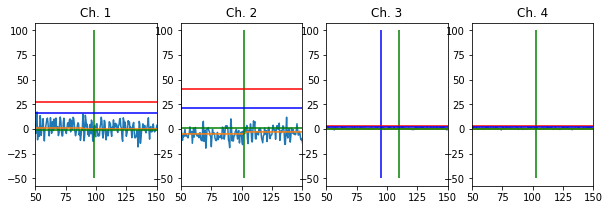

Event Number 2
Channel 1 params: -2.86, 95.3, 87.87, 100.2, 2797.55, -0.018
Channel 2 params: -6.56, 60.9, 0.04, 77.0, 1216.07, -0.108
Channel 3 params: -4.18, 147.6, 2.36, 149.1, 488.12, -0.035
Channel 4 params: -4.07, 101.4, 0.05, 98.9, -121.53, -0.000


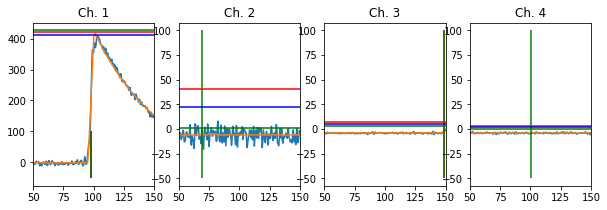

Event Number 3
Channel 1 params: -2.68, 87.9, 49.56, 96.2, 2786.28, -0.019
Channel 2 params: -6.36, 104.0, 7.38, 113.8, 1283.07, -0.026
Channel 3 params: -4.38, 85.0, 1.74, 108.7, 254.68, -0.017
Channel 4 params: -4.45, 89.6, 3.51, 97.0, 128.20, -0.016


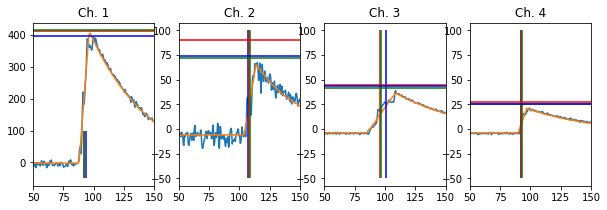

Event Number 4
Channel 1 params: -4.65, 306.7, 0.07, 332.4, 0.00, 0.055
Channel 2 params: -4.69, 79.6, 22.73, 94.1, 1745.71, -0.017
Channel 3 params: -4.36, 94.7, -0.14, 95.7, -71.47, -0.059
Channel 4 params: -4.66, 99.5, 4.66, 101.0, 35.16, -0.016


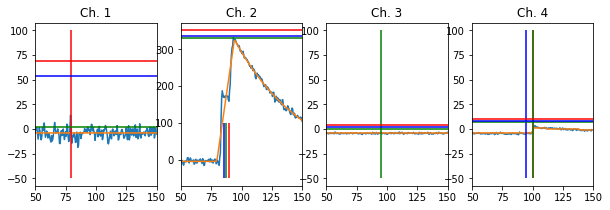

Event Number 5
Channel 1 params: -11.01, 258.4, 0.05, 438.6, 467.42, -0.076
Channel 2 params: -5.08, 91.2, 43.62, 103.2, 3195.23, -0.017
Channel 3 params: -4.18, 92.0, 2.18, 103.7, 139.55, -0.016
Channel 4 params: -4.32, 94.3, 4.08, 102.9, 180.71, -0.016


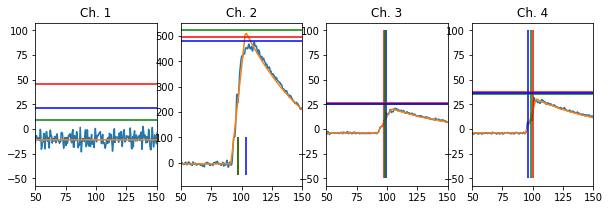

Event Number 6
Channel 1 params: -3.62, 117.6, 0.17, 113.2, -1016.22, -0.000
Channel 2 params: -3.76, 90.3, 69.02, 95.1, 1825.89, -0.017
Channel 3 params: -4.33, 122.5, 0.13, 120.9, -15.34, -0.000
Channel 4 params: -4.33, 105.9, 0.08, 104.0, -91.99, -0.000


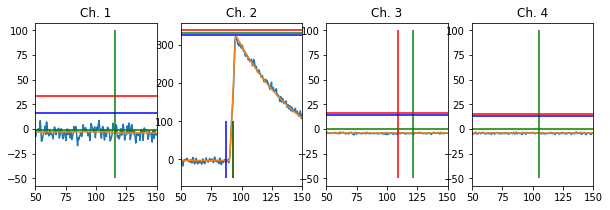

Event Number 7
Channel 1 params: -3.83, 89.7, 62.58, 95.6, 2342.34, -0.019
Channel 2 params: -2.40, 103.4, -1.70, 105.4, -397.75, -0.045
Channel 3 params: -4.31, 102.9, -0.23, 104.0, -1.10, -0.004
Channel 4 params: -4.75, 102.1, -0.22, 102.2, -247.57, -0.000


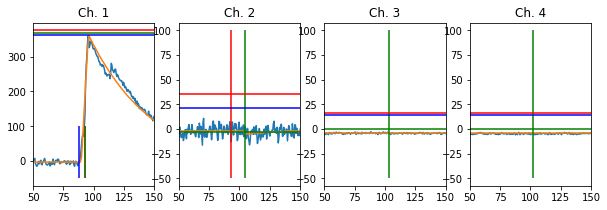

Event Number 8
Channel 1 params: -11.34, 99.7, 0.25, 111.8, 97.43, -0.059
Channel 2 params: -4.69, 93.5, 80.40, 98.0, 2067.11, -0.017
Channel 3 params: -3.86, 115.8, -0.03, 160.3, -54.08, -0.000
Channel 4 params: -4.14, 115.8, -0.00, 223.8, -958.79, -0.031


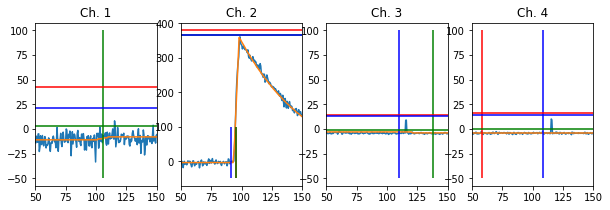

Event Number 9
Channel 1 params: -9.07, 91.6, 38.07, 103.9, 3403.38, -0.019
Channel 2 params: -4.25, 90.0, 23.44, 110.2, 3263.38, -0.017
Channel 3 params: -4.73, 91.0, 3.84, 100.7, 158.56, -0.014
Channel 4 params: -4.52, 94.0, 5.15, 99.7, 111.05, -0.013


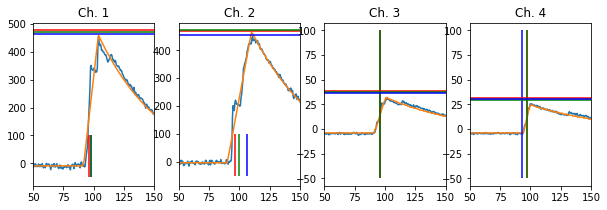

Event Number 10
Channel 1 params: -6.54, 335.0, 0.16, 539.1, 287.40, -0.086
Channel 2 params: -4.39, 88.8, 60.84, 98.1, 3006.65, -0.016
Channel 3 params: -3.21, 89.1, 2.19, 106.4, 214.26, -0.016
Channel 4 params: -4.76, 91.1, 1.62, 109.9, 211.43, -0.018


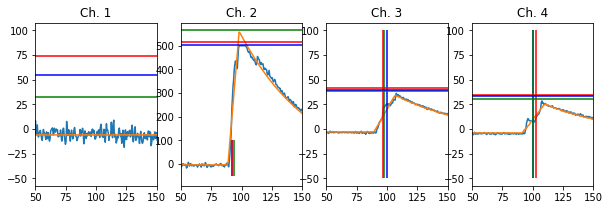

Event Number 11
Channel 1 params: -3.41, 113.9, -0.55, 115.8, -3.84, -0.010
Channel 2 params: -4.80, 87.1, 49.70, 94.1, 1736.75, -0.016
Channel 3 params: -4.31, 104.1, -0.06, 101.9, 10659.63, -0.105
Channel 4 params: -4.82, 101.3, 1.33, 103.9, 22.90, -0.018


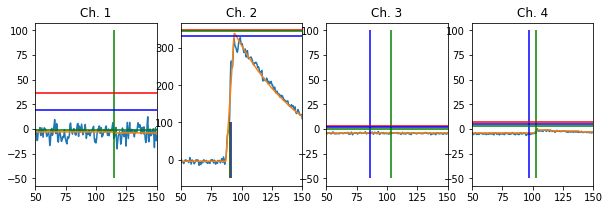

Event Number 12
Channel 1 params: -4.17, 93.4, 19.39, 97.8, 740.94, -0.022
Channel 2 params: -6.87, 91.6, 48.24, 102.8, 3273.54, -0.017
Channel 3 params: -4.49, 90.5, 0.80, 102.7, 61.13, -0.018
Channel 4 params: -4.46, 88.5, 0.22, 113.8, 40.79, -0.018


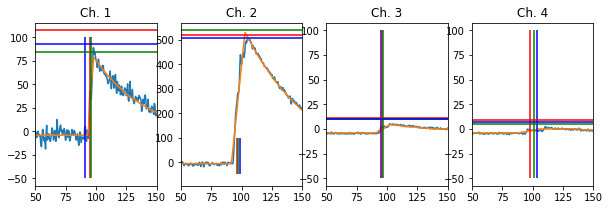

Event Number 13
Channel 1 params: 7.48, 97.7, 434.99, 98.6, 2332.65, -0.017
Channel 2 params: -3.14, 103.5, -0.51, 109.0, -48.35, -0.000
Channel 3 params: -4.69, 94.5, -0.01, 101.7, -1.80, -0.001
Channel 4 params: -4.45, 101.5, -0.18, 102.0, -10.74, -0.000


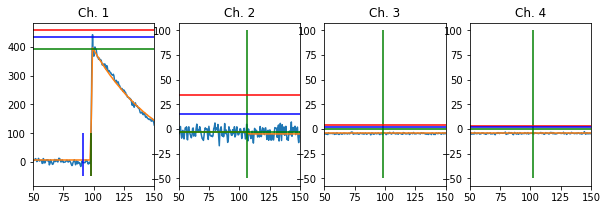

Event Number 14
Channel 1 params: -4.41, 108.4, 0.53, 104.3, -2680.43, -0.000
Channel 2 params: -5.58, 92.3, 78.88, 97.2, 1880.43, -0.015
Channel 3 params: -4.58, 90.2, 1.54, 107.2, 142.27, -0.016
Channel 4 params: -4.75, 92.4, 0.58, 103.7, 53.22, -0.020


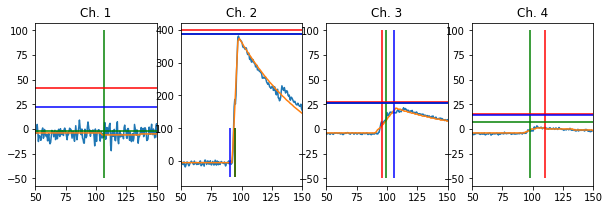

Event Number 15
Channel 1 params: -12.37, 89.6, 51.79, 90.5, 374.45, -0.024
Channel 2 params: -6.23, 87.0, 33.01, 99.4, 2305.04, -0.017
Channel 3 params: -3.82, 118.1, 0.17, 116.9, 56.46, -0.044
Channel 4 params: -4.38, 115.5, 0.02, 138.8, 45.89, -0.032


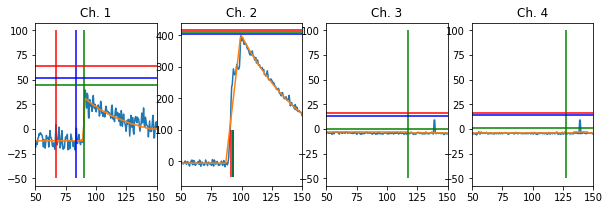

Event Number 16
Channel 1 params: -2.97, 88.9, 39.98, 100.3, 2752.18, -0.017
Channel 2 params: -2.97, 88.2, 67.97, 96.9, 2831.18, -0.015
Channel 3 params: -4.46, 88.9, 1.49, 103.5, 94.98, -0.014
Channel 4 params: -4.81, 86.0, 0.56, 107.7, 90.00, -0.019


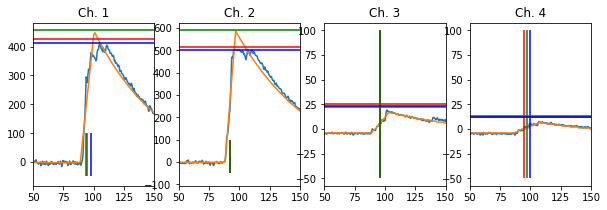

Event Number 17
Channel 1 params: 8.58, 88.0, 49.11, 96.0, 2371.92, -0.017
Channel 2 params: -5.86, 86.8, 11.60, 90.5, 342.65, -0.023
Channel 3 params: -4.46, 83.1, 0.73, 109.1, 105.03, -0.016
Channel 4 params: -4.27, 90.9, 0.68, 104.1, 62.51, -0.018


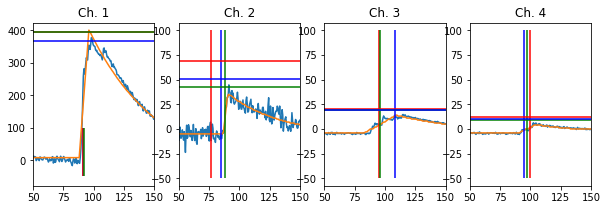

Event Number 18
Channel 1 params: -4.18, 79.4, 20.83, 96.0, 1982.65, -0.017
Channel 2 params: -2.95, 82.2, 17.62, 94.0, 1258.76, -0.018
Channel 3 params: -4.57, 80.5, 2.38, 93.5, 139.48, -0.016
Channel 4 params: -4.65, 85.0, 5.69, 92.4, 155.27, -0.014


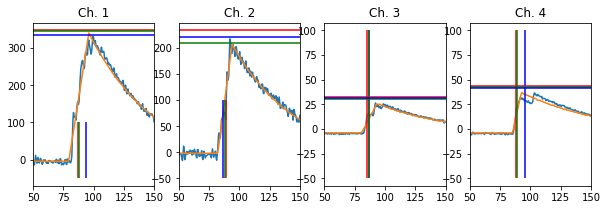

Event Number 19
Channel 1 params: -5.06, 94.3, 104.51, 97.7, 2295.90, -0.018
Channel 2 params: -4.47, 116.2, 0.09, 122.2, -7.60, -0.053
Channel 3 params: -4.34, 104.1, 0.07, 105.4, 25.07, -0.055
Channel 4 params: -4.63, 126.0, -0.02, 106.1, 6705.68, -0.095


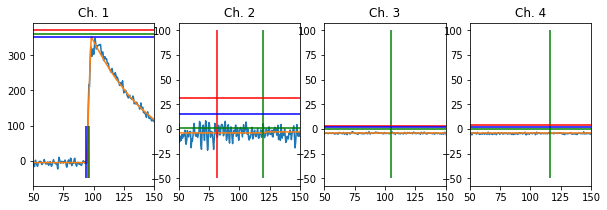

Event Number 20
Channel 1 params: -5.82, 91.9, 52.13, 100.9, 2794.58, -0.017
Channel 2 params: -4.90, 85.8, 17.89, 110.2, 3104.50, -0.017
Channel 3 params: -4.42, 90.6, 2.34, 105.2, 198.85, -0.017
Channel 4 params: -4.58, 91.3, 1.04, 106.5, 104.48, -0.018


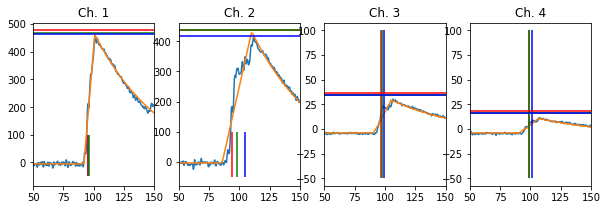

Event Number 21
Channel 1 params: -10.76, 111.8, 0.26, 121.8, 419.13, -0.073
Channel 2 params: -3.39, 89.5, 47.73, 99.7, 2817.16, -0.017
Channel 3 params: -4.62, 90.7, 3.61, 97.9, 137.78, -0.017
Channel 4 params: -4.31, 93.0, 6.79, 96.7, 96.60, -0.014


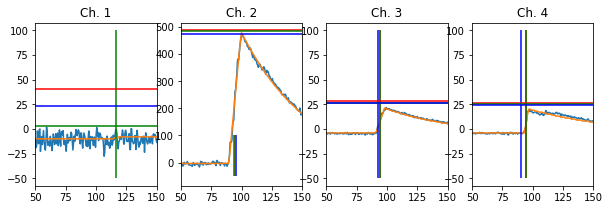

Event Number 22
Channel 1 params: -8.88, 102.1, 0.18, 111.1, 131.12, -0.063
Channel 2 params: -4.51, 90.2, 57.61, 99.2, 2923.28, -0.017
Channel 3 params: 468.22, -57509.1, -0.01, 247.4, -139276877.85, -0.072
Channel 4 params: -4.62, 92.4, 0.00, 127.2, 64.17, -0.059


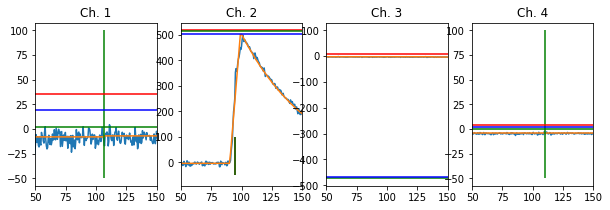

Event Number 23
Channel 1 params: -6.17, 89.9, 50.14, 98.2, 2821.76, -0.019
Channel 2 params: -4.60, 234.9, 0.02, 365.4, -251.40, -0.074
Channel 3 params: -4.55, 109.0, 0.04, 99.7, -1.25, -0.007
Channel 4 params: -4.33, 97.6, -0.02, 113.0, -8.45, -0.000


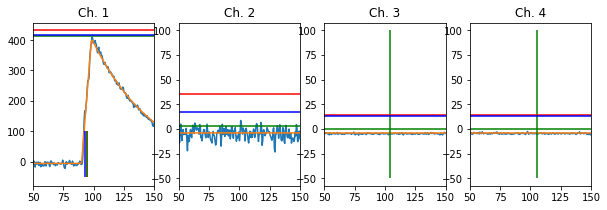

Event Number 24
Channel 1 params: -5.88, 84.2, 35.33, 96.8, 2487.88, -0.017
Channel 2 params: -8.05, 111.3, 1.68, 110.1, -11643.88, -0.000
Channel 3 params: -4.48, 80.6, 0.67, 98.4, 76.78, -0.020
Channel 4 params: -4.68, 84.1, 1.03, 104.2, 113.74, -0.016


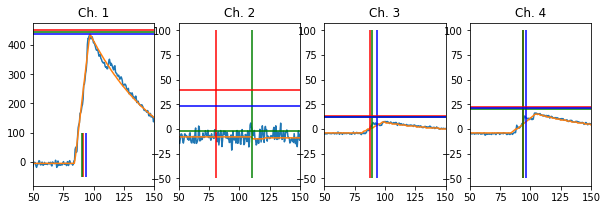

Event Number 25
Channel 1 params: -0.92, 80.3, 25.42, 96.1, 2276.14, -0.017
Channel 2 params: 4.89, 132.6, -0.47, 123.7, 9424.73, -0.053
Channel 3 params: -4.14, 82.6, 5.60, 95.6, 314.29, -0.015
Channel 4 params: -4.34, 83.5, 4.21, 99.3, 297.24, -0.015


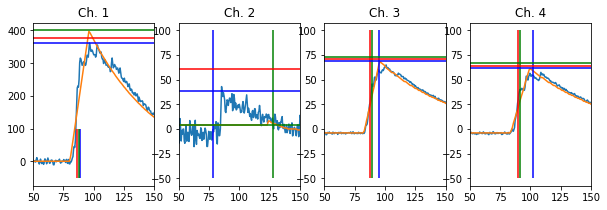

Event Number 26
Channel 1 params: -4.66, 92.2, 37.62, 104.1, 2776.00, -0.017
Channel 2 params: -0.30, 88.4, 9.44, 110.0, 1354.26, -0.016
Channel 3 params: -4.34, 93.5, 2.34, 102.0, 129.45, -0.019
Channel 4 params: -4.59, 98.3, 0.03, 86.6, -1536.61, -0.000


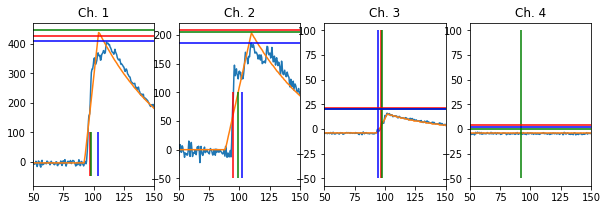

Event Number 27
Channel 1 params: -3.52, 92.3, 74.32, 97.4, 1592.79, -0.014
Channel 2 params: -4.96, 80.6, -0.01, 272.6, -960.23, -0.019
Channel 3 params: -4.54, 86.8, 0.91, 105.3, 78.63, -0.014
Channel 4 params: -4.84, 89.5, 1.23, 100.0, 70.09, -0.017


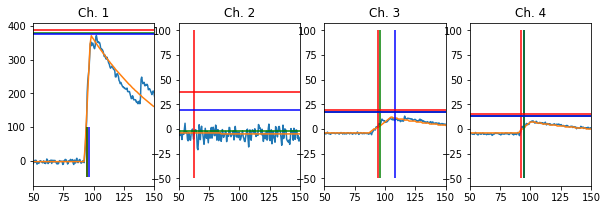

Event Number 28
Channel 1 params: -4.33, 103.4, 0.42, 92.3, -20275.82, -0.000
Channel 2 params: -1.94, 90.9, 45.51, 100.5, 2804.84, -0.018
Channel 3 params: -4.50, 106.2, 0.08, 104.3, -1.16, -0.002
Channel 4 params: -4.55, 103.0, -0.34, 103.1, -260.57, -0.000


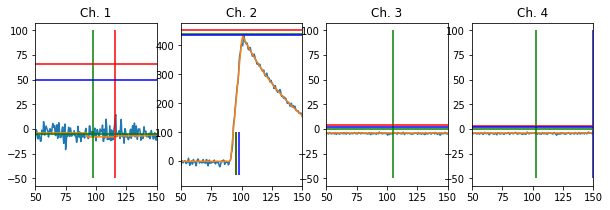

Event Number 29
Channel 1 params: -8.68, 84.5, 48.20, 91.5, 1965.54, -0.019
Channel 2 params: 5.38, 83.0, 32.12, 95.7, 2350.38, -0.017
Channel 3 params: 0.00, 81.1, 1.09, 114.2, 211.18, -0.014
Channel 4 params: -1.78, 84.8, 3.90, 89.1, 53.65, -0.012


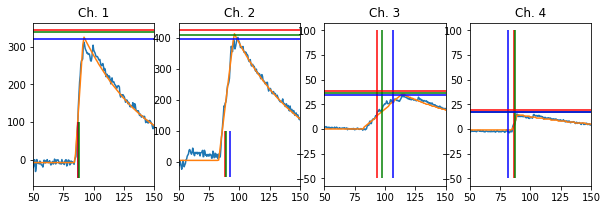

Event Number 30
Channel 1 params: -4.48, 87.6, 57.73, 94.3, 1998.94, -0.017
Channel 2 params: -5.91, 82.8, 12.17, 106.5, 2196.36, -0.018
Channel 3 params: -4.43, 83.5, 1.69, 95.1, 66.41, -0.012
Channel 4 params: -4.58, 89.2, 6.71, 94.1, 145.21, -0.016


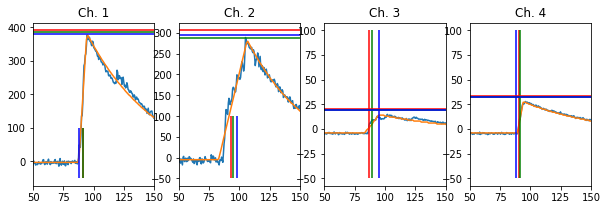

Event Number 31
Channel 1 params: -3.33, 103.9, -0.97, 104.7, -354.63, -0.061
Channel 2 params: -1.24, 87.3, 51.93, 93.9, 1612.71, -0.016
Channel 3 params: -4.64, 100.4, 0.14, 102.7, 40.20, -0.051
Channel 4 params: -4.45, 104.9, 0.16, 104.0, -315.03, -0.000


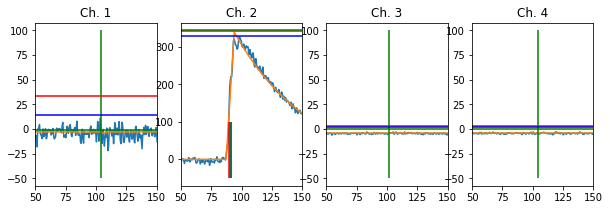

Event Number 32
Channel 1 params: -5.17, 100.4, 0.38, 88.6, -10051.98, -0.000
Channel 2 params: -2.56, 83.5, 33.81, 96.1, 1803.51, -0.014
Channel 3 params: -4.46, 84.8, 3.11, 99.0, 184.55, -0.014
Channel 4 params: -4.45, 86.6, 5.50, 91.5, 82.47, -0.012


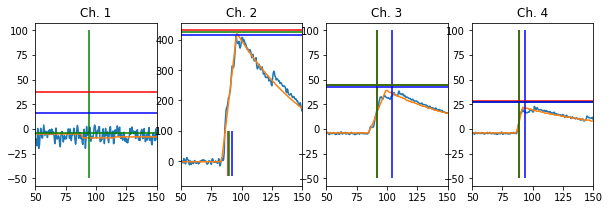

Event Number 33
Channel 1 params: -5.70, 92.4, 11.39, 101.5, 451.55, -0.014
Channel 2 params: -11.52, 90.2, 39.93, 101.2, 2630.80, -0.017
Channel 3 params: -4.64, 89.3, 6.11, 101.4, 327.81, -0.014
Channel 4 params: -4.50, 91.7, 7.17, 99.2, 254.16, -0.015


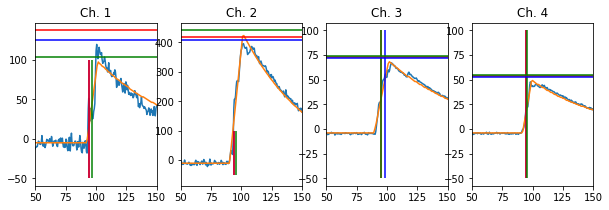

Event Number 34
Channel 1 params: -3.13, 88.9, 31.13, 102.8, 2929.34, -0.018
Channel 2 params: -4.21, 112.7, 0.73, 108.8, -2861.92, -0.000
Channel 3 params: -4.44, 464.3, 0.56, 468.6, 97.54, -0.101
Channel 4 params: -4.21, 101.7, -0.00, 91.0, 2.25, -0.029


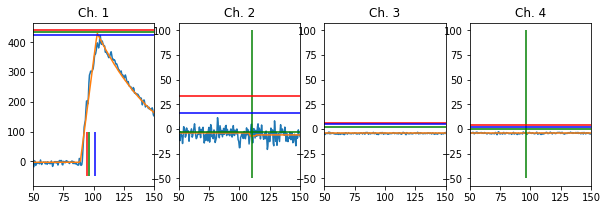

Event Number 35
Channel 1 params: 115.99, -5932.3, -0.02, 327.0, -297290172.13, -0.051
Channel 2 params: -8.80, 77.4, 22.19, 92.4, 1624.27, -0.016
Channel 3 params: -4.68, 111.9, -0.00, 94.1, -303.63, -0.000
Channel 4 params: -4.53, 110.2, -0.02, 109.0, -51.43, -0.142


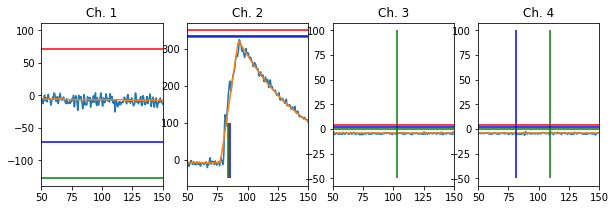

Event Number 36
Channel 1 params: -5.58, 94.1, 58.86, 100.2, 1868.30, -0.016
Channel 2 params: -7.19, 101.1, 0.44, 103.7, -864.23, -0.115
Channel 3 params: -4.68, 125.9, 0.50, 132.7, 53.17, -0.021
Channel 4 params: -4.51, 105.2, 0.20, 106.1, 20.62, -0.045


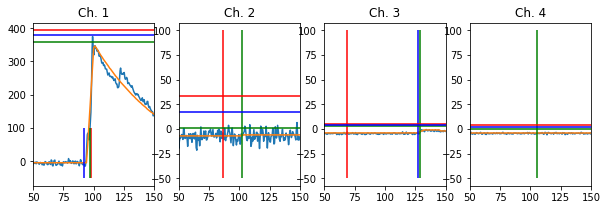

Event Number 37
Channel 1 params: -5.65, 86.0, 43.75, 95.0, 1998.08, -0.016
Channel 2 params: -6.47, 104.9, -0.12, 111.5, -52.47, -0.000
Channel 3 params: -2.85, -10457.9, -0.00, 312.6, -142095099.96, -0.059
Channel 4 params: -4.81, 106.4, -0.29, 107.4, -15.69, -0.035


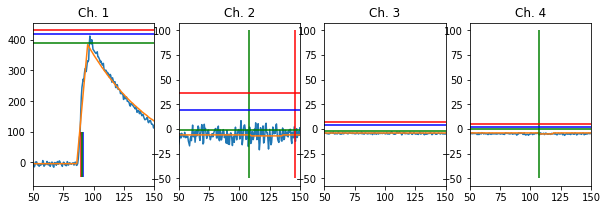

Event Number 38
Channel 1 params: -7.73, 87.4, 55.88, 93.9, 1591.17, -0.015
Channel 2 params: -3.58, 90.9, -0.04, 252.7, -96069029860.14, -0.088
Channel 3 params: -4.29, 88.2, 5.77, 98.6, 246.19, -0.014
Channel 4 params: -4.36, 88.8, 3.82, 100.0, 172.60, -0.014


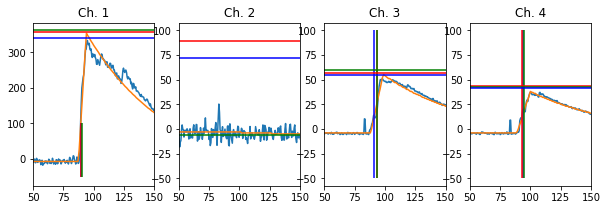

Event Number 39
Channel 1 params: -4.52, 119.4, -0.24, 108.2, -582.34, -0.162
Channel 2 params: -3.27, 95.3, 128.78, 98.0, 1605.82, -0.015
Channel 3 params: -4.25, 105.4, -0.24, 106.0, -0.63, -0.003
Channel 4 params: -4.44, 91.3, -0.06, 96.8, -1.37, -0.001


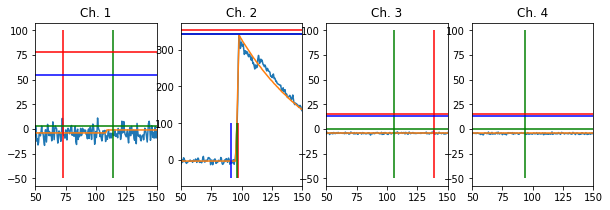

Event Number 40
Channel 1 params: -7.34, 87.2, 31.38, 98.9, 2221.15, -0.018
Channel 2 params: -3.86, 102.9, 0.85, 92.1, -121.43, -0.000
Channel 3 params: -4.48, 91.3, 1.40, 96.2, 38.27, -0.018
Channel 4 params: -4.56, 100.0, 0.01, 89.1, -899.00, -0.000


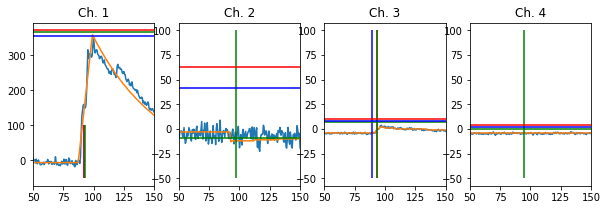

Event Number 41
Channel 1 params: -7.89, 95.3, 24.85, 97.2, 819.40, -0.029
Channel 2 params: -7.57, 92.8, 59.91, 102.1, 2767.58, -0.015
Channel 3 params: -4.04, 92.0, 2.78, 107.2, 215.38, -0.015
Channel 4 params: -4.57, 94.3, 1.57, 110.3, 213.63, -0.020


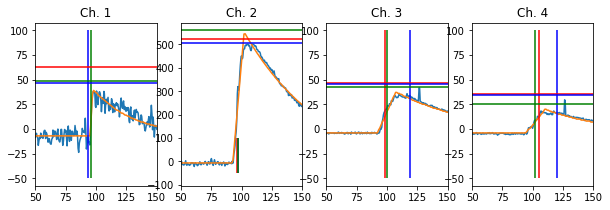

Event Number 42
Channel 1 params: -4.04, 107.1, 0.09, 124.2, 377.21, -0.061
Channel 2 params: -5.49, 91.6, 50.57, 99.3, 2229.14, -0.017
Channel 3 params: -4.41, 92.9, 1.98, 103.9, 117.05, -0.016
Channel 4 params: -4.62, 94.8, 3.49, 105.9, 193.57, -0.015


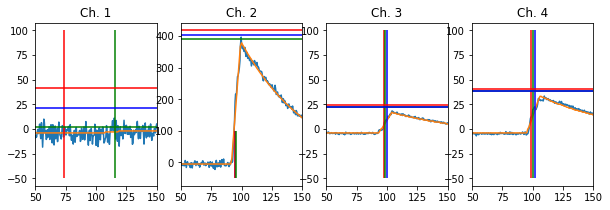

Event Number 43
Channel 1 params: -6.24, 73.3, 14.19, 97.0, 2225.82, -0.019
Channel 2 params: -5.60, 85.8, -0.14, 102.3, -9.57, -0.003
Channel 3 params: -4.27, 98.7, -0.07, 102.3, -0.66, -0.003
Channel 4 params: -4.54, 103.7, -0.23, 105.3, -5.11, -0.025


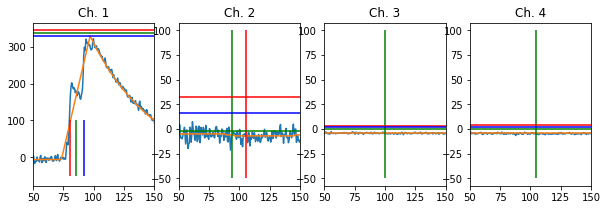

Event Number 44
Channel 1 params: -5.17, 89.3, 33.24, 102.7, 2255.77, -0.015
Channel 2 params: 0.73, 113.4, -0.64, 79.6, 211.04, -0.025
Channel 3 params: -4.52, 91.7, 3.01, 103.5, 165.61, -0.014
Channel 4 params: -4.81, 96.6, 5.95, 97.5, 10.63, -0.003


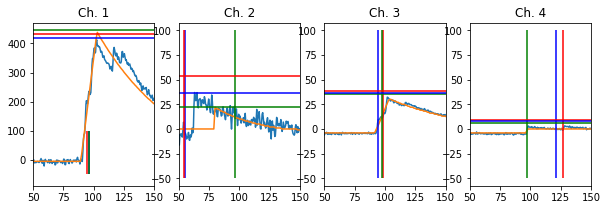

Event Number 45
Channel 1 params: -4.44, 112.3, -0.16, 110.2, -1070.18, -0.079
Channel 2 params: -4.20, 91.1, 40.44, 103.8, 2921.75, -0.016
Channel 3 params: -4.36, 93.4, 0.90, 109.7, 80.55, -0.015
Channel 4 params: -4.60, 95.6, 3.11, 97.8, 35.35, -0.017


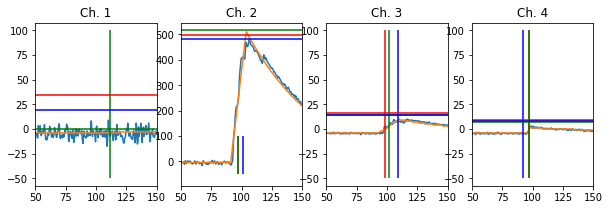

Event Number 46
Channel 1 params: -3.07, 86.9, 26.39, 100.9, 2899.59, -0.019
Channel 2 params: -3.81, 86.8, 16.39, 103.0, 1842.91, -0.018
Channel 3 params: -4.37, 88.9, 3.40, 96.9, 102.18, -0.013
Channel 4 params: -4.40, 89.0, 0.88, 99.7, 60.78, -0.018


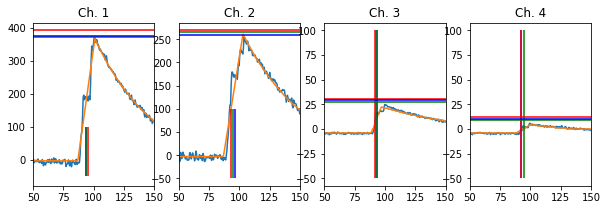

Event Number 47
Channel 1 params: -4.79, 93.3, 80.02, 99.7, 3088.62, -0.017
Channel 2 params: -4.26, 109.1, 0.54, 103.4, -354.41, -0.000
Channel 3 params: -4.42, 158.3, 2.96, 159.5, 20.37, -0.011
Channel 4 params: -4.92, 280.0, 0.00, 622.1, -143.89, -0.170


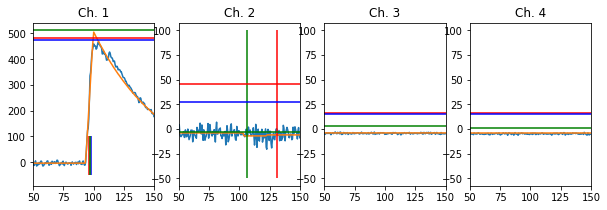

Event Number 48
Channel 1 params: -6.21, 89.7, 38.46, 101.3, 2801.66, -0.017
Channel 2 params: -8.14, 116.9, -0.30, 123.7, -25.03, -0.001
Channel 3 params: -4.71, 107.7, -0.00, 115.9, -26.64, -0.000
Channel 4 params: -4.59, 106.4, 0.12, 104.7, -355.02, -0.000


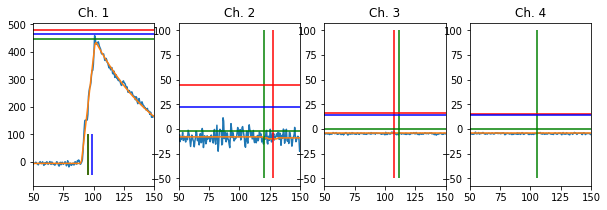

Event Number 49
Channel 1 params: -3.98, 88.4, 45.89, 98.6, 3036.02, -0.018
Channel 2 params: 21.23, 84.9, -0.36, 119.5, 604.04, -0.029
Channel 3 params: -4.41, 91.5, 2.52, 94.3, 41.49, -0.019
Channel 4 params: -4.49, 91.3, 5.07, 93.6, 37.14, -0.013


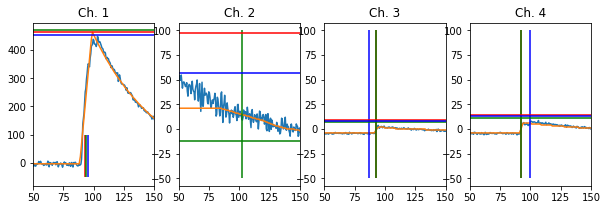

Event Number 50
Channel 1 params: -7.03, 112.3, 0.24, 108.8, -2782.20, -0.000
Channel 2 params: -9.36, 76.5, 22.18, 91.4, 1626.64, -0.017
Channel 3 params: -4.69, 111.2, -0.00, 202.9, -7.37, -0.013
Channel 4 params: -4.35, 39.4, -0.00, 257.8, -1139.56, -0.027


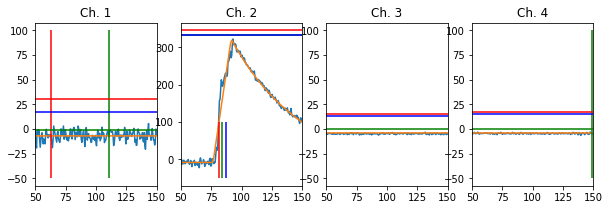

Event Number 51
Channel 1 params: -6.22, 95.4, 9.26, 100.4, 890.25, -0.029
Channel 2 params: -670.13, -99.1, 4.82, 147.9, 7500.65, -0.017
Channel 3 params: -4.57, 97.9, 0.08, 91.2, -892.68, -0.000
Channel 4 params: -4.86, 122.9, -0.11, 126.4, -30.35, -0.000


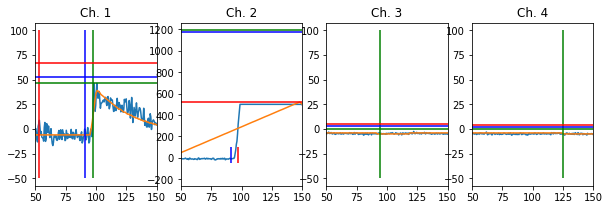

Event Number 52
Channel 1 params: -3.44, 120.1, 0.52, 113.5, -4917.32, -0.000
Channel 2 params: 6.80, 92.2, 48.55, 103.2, 2821.31, -0.015
Channel 3 params: -4.52, 101.0, 0.04, 93.2, -4.55, -0.000
Channel 4 params: -4.54, 104.9, -0.00, 85.7, 0.69, -0.056


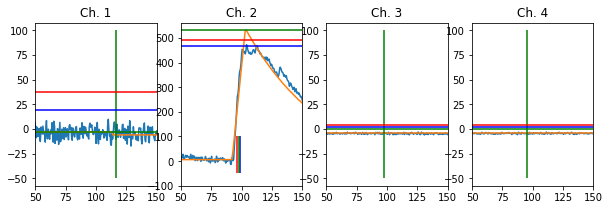

Event Number 53
Channel 1 params: -2.55, 87.3, 31.59, 94.8, 1484.71, -0.019
Channel 2 params: 12.50, 88.4, 56.31, 95.6, 2211.03, -0.016
Channel 3 params: -4.80, 88.6, 3.70, 97.7, 169.19, -0.016
Channel 4 params: -3.26, 88.1, 3.80, 101.8, 245.45, -0.015


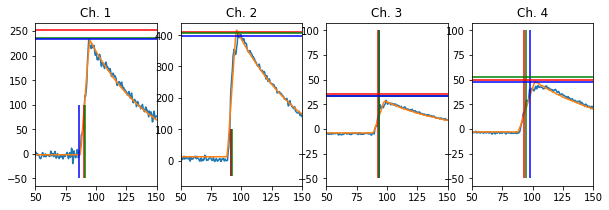

Event Number 54
Channel 1 params: -227.00, -7.8, 4.90, 128.6, 5109.96, -0.018
Channel 2 params: -6.50, 99.3, -0.08, 82.7, 1092.11, -0.172
Channel 3 params: -4.19, 87.1, 2.88, 102.0, 233.60, -0.016
Channel 4 params: -4.58, 90.9, 9.00, 100.4, 367.68, -0.014


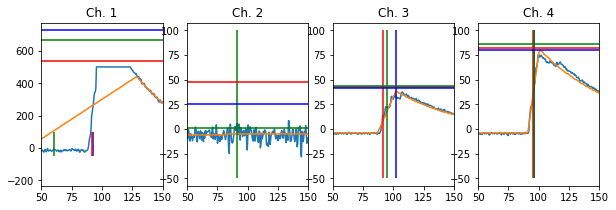

Event Number 55
Channel 1 params: -9.38, 92.9, 7.74, 106.0, 718.98, -0.018
Channel 2 params: -4.22, 93.9, 72.75, 100.0, 1809.15, -0.013
Channel 3 params: -4.47, 96.3, 4.62, 103.2, 137.71, -0.014
Channel 4 params: -4.54, 94.6, 2.05, 105.1, 113.77, -0.016


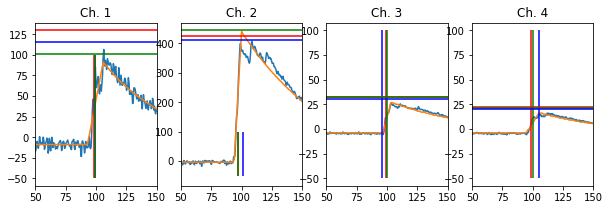

Event Number 56
Channel 1 params: -3.17, 92.3, 62.49, 99.6, 2997.64, -0.018
Channel 2 params: 12.47, 112.6, 1.00, 104.6, 683.63, -0.040
Channel 3 params: -4.58, 103.6, 3.27, 104.6, 233.55, -0.046
Channel 4 params: -4.19, 92.9, 1.16, 100.7, 50.85, -0.017


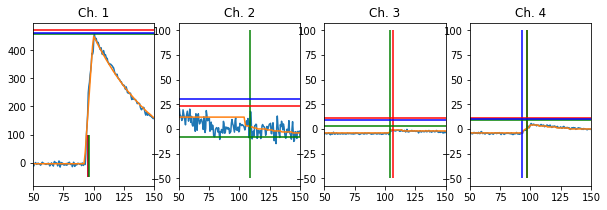

Event Number 57
Channel 1 params: -3.71, 92.6, 77.23, 97.7, 2445.03, -0.018
Channel 2 params: -5.50, 92.2, 29.62, 101.6, 1239.72, -0.014
Channel 3 params: -4.43, 91.1, 1.14, 105.3, 100.37, -0.017
Channel 4 params: -4.37, 90.3, 1.25, 109.0, 116.26, -0.014


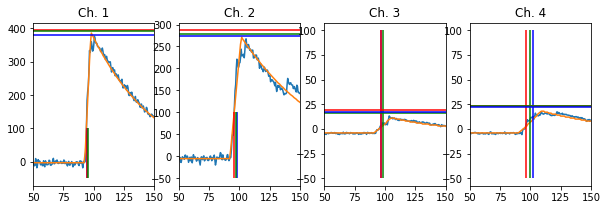

Event Number 58
Channel 1 params: -6.16, 88.8, 47.85, 99.5, 3449.86, -0.018
Channel 2 params: -5.19, 88.9, 33.96, 103.4, 3105.87, -0.017
Channel 3 params: -4.63, 87.7, 1.15, 105.3, 118.05, -0.017
Channel 4 params: -4.52, 92.2, 2.64, 103.5, 149.41, -0.015


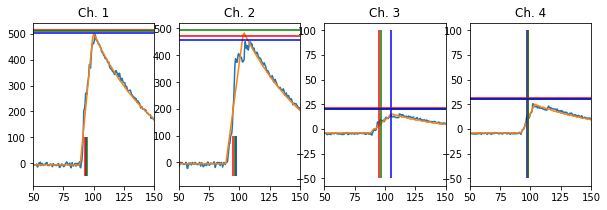

Event Number 59
Channel 1 params: -8.79, 71.0, 14.34, 102.9, 2888.73, -0.017
Channel 2 params: -3.13, 107.9, 1.01, 103.0, -28.84, -0.004
Channel 3 params: -4.42, 264.5, 0.01, 298.5, -39.22, -0.091
Channel 4 params: -4.69, 316.6, 0.01, 352.8, 6.23, -0.111


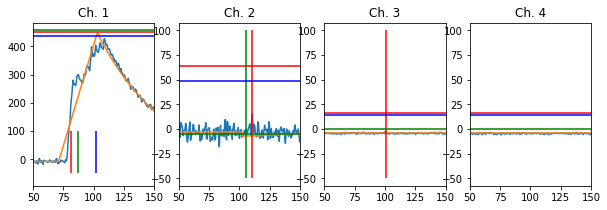

Event Number 60
Channel 1 params: -2.83, 92.8, 100.56, 96.0, 1896.02, -0.018
Channel 2 params: -5.78, 99.5, -1.53, 101.0, -47.97, -0.025
Channel 3 params: -4.33, 106.3, 0.06, 107.6, 16.10, -0.056
Channel 4 params: -2.25, 26.6, -0.02, 75.5, 5.05, -0.019


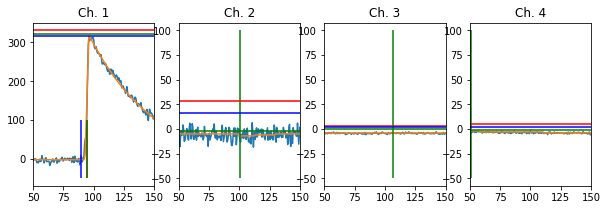

Event Number 61
Channel 1 params: -622.73, -143.4, 3.46, 118.8, 3042.54, -0.019
Channel 2 params: -6.60, 268.6, 0.03, 361.3, -55085321.19, -0.042
Channel 3 params: -4.57, 171.4, 0.22, 205.3, 116.25, -0.013
Channel 4 params: -4.52, 103.4, 0.02, 110.9, -21.03, -0.075


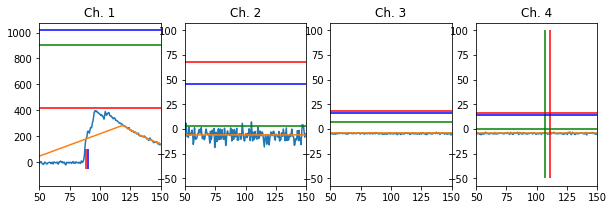

Event Number 62
Channel 1 params: -5.76, 91.3, 49.82, 100.8, 2917.58, -0.017
Channel 2 params: -7.26, 92.2, 12.23, 103.6, 1139.00, -0.020
Channel 3 params: -4.58, 90.4, 4.69, 104.0, 308.25, -0.015
Channel 4 params: -4.63, 94.2, 2.17, 103.9, 97.69, -0.015


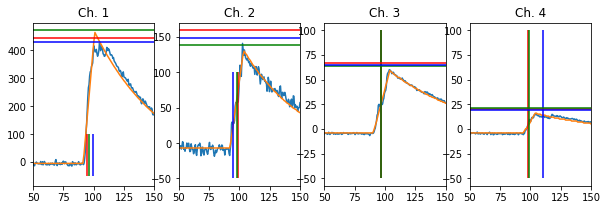

Event Number 63
Channel 1 params: -8.24, 89.1, 54.25, 95.3, 1597.78, -0.015
Channel 2 params: -5.21, 107.4, -0.74, 108.0, -54.12, -0.047
Channel 3 params: -4.28, 103.4, -0.12, 103.9, -37.40, -0.055
Channel 4 params: -0.21, -4994.6, -0.00, 324.4, -59004411.64, -0.054


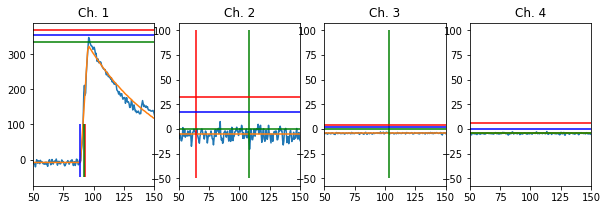

Event Number 64
Channel 1 params: -3.76, 102.3, 19.17, 105.1, 1634.74, -0.034
Channel 2 params: -515.61, -65.8, 5.00, 136.8, 5672.44, -0.017
Channel 3 params: -4.56, 90.0, 0.48, 115.3, 132.40, -0.021
Channel 4 params: -4.67, 92.8, 0.94, 109.6, 125.58, -0.019


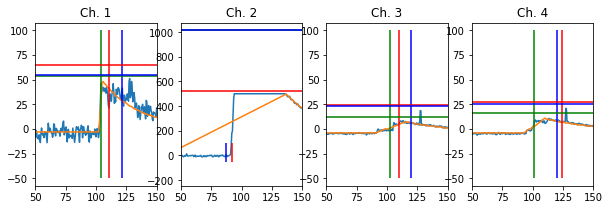

Event Number 65
Channel 1 params: -2.26, 84.6, 29.57, 106.9, 2775.36, -0.012
Channel 2 params: -3.02, 90.0, -0.41, 86.5, 608.59, -0.149
Channel 3 params: -4.16, 87.3, 3.13, 102.6, 232.85, -0.015
Channel 4 params: -4.72, 90.1, 2.97, 102.8, 127.05, -0.012


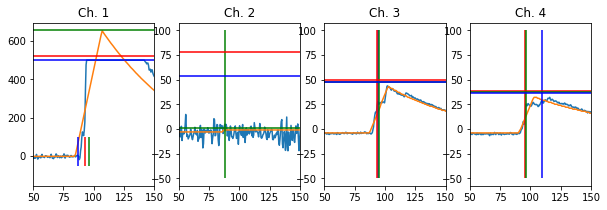

Event Number 66
Channel 1 params: 2.00, 131.5, -0.57, 110.8, 266.73, -0.023
Channel 2 params: -4.95, 77.7, 22.51, 92.3, 1702.30, -0.017
Channel 3 params: -4.72, 103.3, -0.34, 104.3, -70.52, -0.045
Channel 4 params: -3.54, 125.2, 2.04, 127.0, 52.24, -0.019


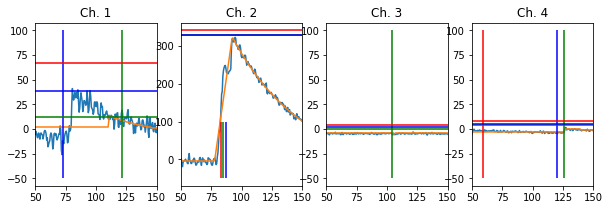

Event Number 67
Channel 1 params: -4.71, 89.9, 55.54, 99.8, 3550.03, -0.018
Channel 2 params: -6.87, 88.0, 9.79, 105.3, 2136.03, -0.024
Channel 3 params: -3.90, 90.7, 2.68, 98.3, 80.91, -0.013
Channel 4 params: -4.57, 94.1, 0.97, 105.8, 54.01, -0.015


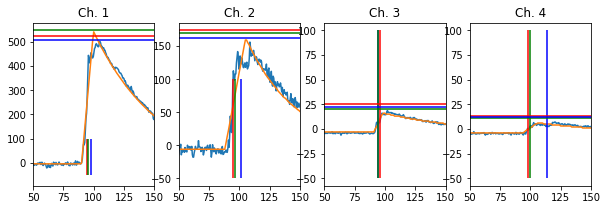

Event Number 68
Channel 1 params: -4.38, 85.2, 40.56, 93.9, 1393.37, -0.014
Channel 2 params: -20.30, -4291.6, 0.00, 390.4, -51104005.88, -0.038
Channel 3 params: -4.32, 89.8, 2.09, 96.8, 43.81, -0.011
Channel 4 params: -4.42, 86.8, 1.63, 98.2, 61.46, -0.012


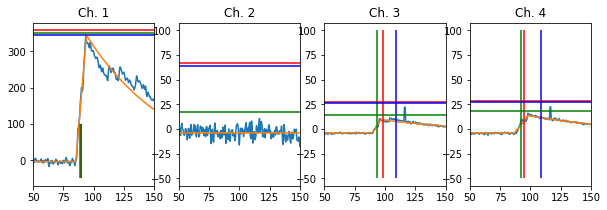

Event Number 69
Channel 1 params: -5.55, 88.0, 36.59, 97.3, 1870.73, -0.017
Channel 2 params: -7.10, 103.3, 0.81, 104.2, -5.52, -0.002
Channel 3 params: -4.52, 207.6, -0.00, 271.8, -2162566.42, -0.051
Channel 4 params: -4.23, 122.0, 0.03, 106.2, 3.37, -0.015


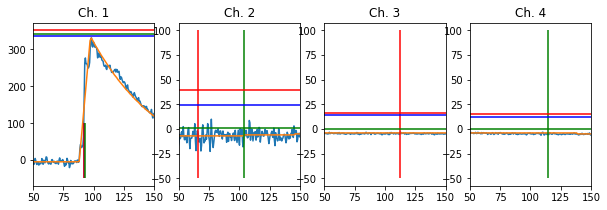

Event Number 70
Channel 1 params: -5.38, 90.9, 85.71, 95.5, 2413.86, -0.018
Channel 2 params: -7.79, 133.8, 0.19, 103.6, -17102.64, -0.000
Channel 3 params: -4.46, 92.3, 10.46, 95.1, 120.91, -0.015
Channel 4 params: -4.69, 89.3, 0.93, 99.6, 48.87, -0.016


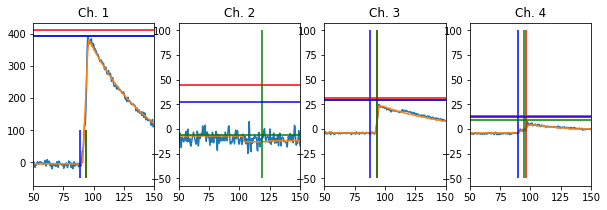

Event Number 71
Channel 1 params: -4.39, 90.3, 41.93, 98.6, 2150.40, -0.018
Channel 2 params: -8.51, 105.7, 1.07, 105.6, -70.60, -0.000
Channel 3 params: -4.63, 108.9, -0.16, 109.8, -216.42, -0.059
Channel 4 params: -4.60, 105.8, -0.88, 106.1, -957.87, -0.000


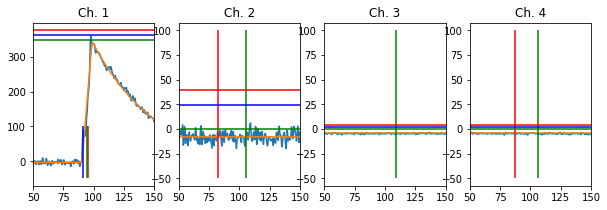

Event Number 72
Channel 1 params: -5.56, 103.5, -1.17, 105.6, -708.84, -0.052
Channel 2 params: -4.47, 85.0, 44.23, 93.2, 1504.10, -0.014
Channel 3 params: -4.52, 90.9, 11.69, 91.8, 48.62, -0.017
Channel 4 params: -4.68, 97.9, 6.57, 98.5, 23.30, -0.019


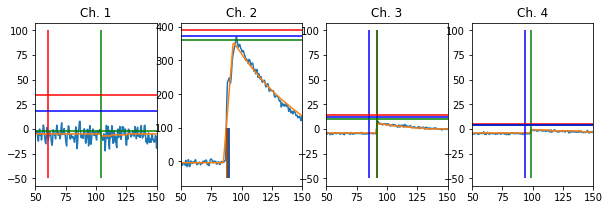

Event Number 73
Channel 1 params: -6.05, 106.8, 0.51, 91.2, -21171.08, -0.000
Channel 2 params: -6.27, 87.1, 56.03, 94.7, 2763.90, -0.019
Channel 3 params: -4.54, 87.4, 10.30, 97.9, 344.22, -0.011
Channel 4 params: -4.56, 88.0, 4.52, 102.4, 283.10, -0.014


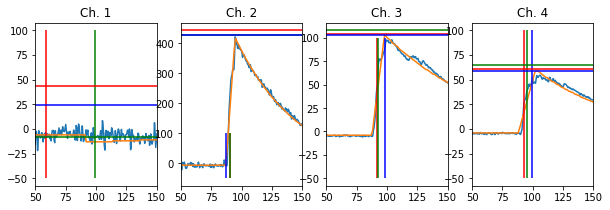

Event Number 74
Channel 1 params: -6.77, 91.0, 102.58, 94.5, 1820.77, -0.016
Channel 2 params: -3.77, 111.7, 0.31, 108.2, -8.28, -0.012
Channel 3 params: -3.18, 130.6, -0.09, 126.3, 32.67, -0.023
Channel 4 params: -4.91, 114.8, 0.74, 115.3, 81.38, -0.144


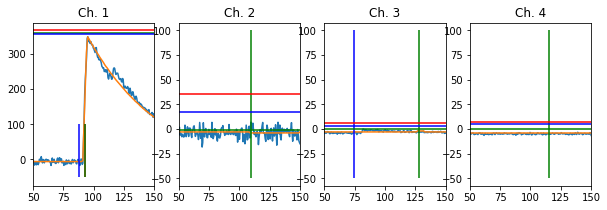

Event Number 75
Channel 1 params: -3.12, 89.9, 38.56, 102.6, 3905.89, -0.020
Channel 2 params: -8.23, 276.0, 0.05, 418.7, -548.72, -0.096
Channel 3 params: -4.52, 90.5, 3.05, 98.7, 91.17, -0.013
Channel 4 params: -4.66, 89.6, 1.95, 107.0, 196.08, -0.016


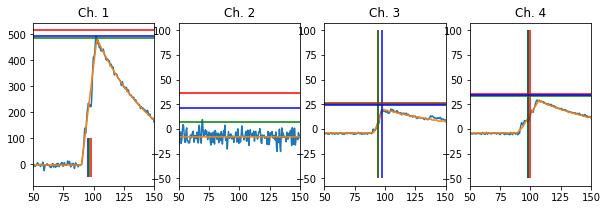

Event Number 76
Channel 1 params: -5.10, 85.7, 16.98, 94.8, 1148.02, -0.021
Channel 2 params: -1.57, 82.1, 20.64, 101.6, 2031.97, -0.015
Channel 3 params: -4.53, 85.0, 2.48, 97.2, 111.63, -0.013
Channel 4 params: -4.66, 87.6, 2.08, 95.5, 79.84, -0.017


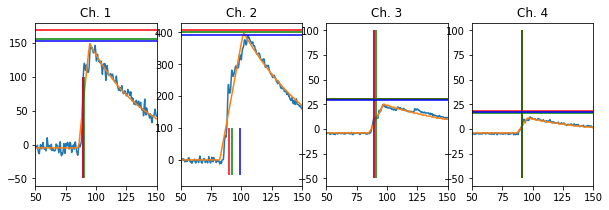

Event Number 77
Channel 1 params: -3.83, 79.3, 21.76, 97.2, 1249.89, -0.011
Channel 2 params: -4.13, 304.6, -0.29, 315.8, -10830.02, -0.020
Channel 3 params: -5.00, 121.4, -0.02, 150.5, -725.55, -0.042
Channel 4 params: -4.62, 108.5, -0.01, 165.1, -47.54, -0.000


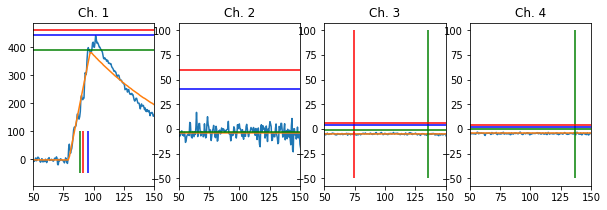

Event Number 78
Channel 1 params: 11.03, 89.8, 26.31, 107.9, 3803.43, -0.018
Channel 2 params: -6.86, 90.9, 44.22, 100.1, 1938.97, -0.015
Channel 3 params: -4.57, 97.4, 3.29, 104.1, 92.82, -0.014
Channel 4 params: -4.61, 96.7, 2.68, 105.2, 134.78, -0.017


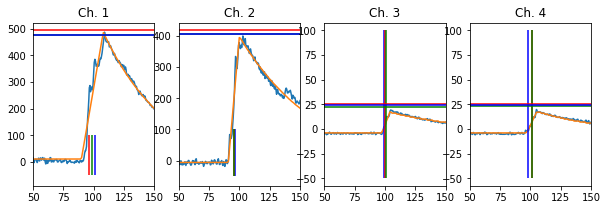

Event Number 79
Channel 1 params: -4510.87, -902.1, 4.79, 136.0, 5971.88, -0.018
Channel 2 params: -3.54, 78.7, -0.04, 246.2, -546.86, -0.015
Channel 3 params: -4.38, 92.0, 3.52, 105.2, 241.03, -0.015
Channel 4 params: -4.50, 95.7, 1.15, 111.8, 115.88, -0.016


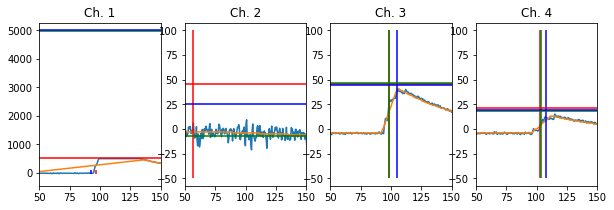

Event Number 80
Channel 1 params: -2.90, 107.5, -0.48, 112.4, -26.32, -0.000
Channel 2 params: -9.21, 89.3, 45.30, 99.9, 2512.71, -0.016
Channel 3 params: -4.54, 105.7, 0.13, 104.1, -1.77, -0.001
Channel 4 params: -4.72, 96.4, 0.00, 131.2, 25.16, -0.096


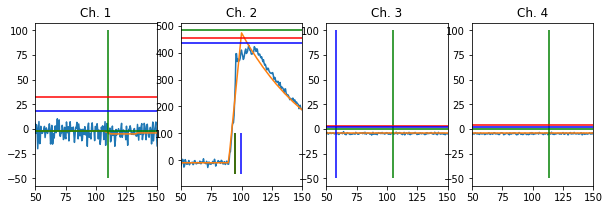

Event Number 81
Channel 1 params: -5.38, 95.4, 139.58, 98.0, 2241.61, -0.018
Channel 2 params: -4.21, 155.9, 38.74, 156.9, 1042.70, -0.021
Channel 3 params: -4.40, 63.3, -0.00, 198.7, -4976.53, -0.043
Channel 4 params: -4.50, 99.0, -0.00, 148.4, -22.75, -0.000


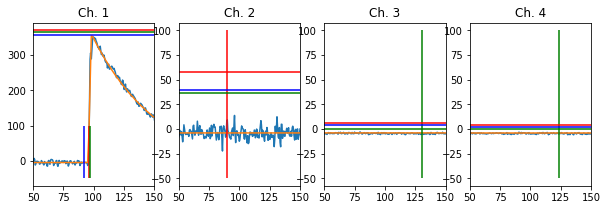

Event Number 82
Channel 1 params: -8.83, 99.2, 0.47, 82.9, -24494.73, -0.000
Channel 2 params: -3.41, 90.1, 33.78, 103.9, 2617.18, -0.016
Channel 3 params: -4.02, 98.1, 2.33, 100.9, 50.14, -0.019
Channel 4 params: -4.70, 86.5, 0.12, 129.9, 60.22, -0.019


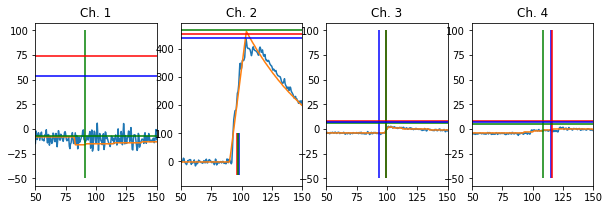

Event Number 83
Channel 1 params: -1.46, 116.0, 0.96, 104.9, -30.78, -0.009
Channel 2 params: -3.47, 74.3, 18.03, 92.4, 1600.53, -0.016
Channel 3 params: -4.26, 88.9, -0.00, 132.8, -1.01, -0.003
Channel 4 params: -4.82, 101.9, 0.15, 100.0, -493.17, -0.000


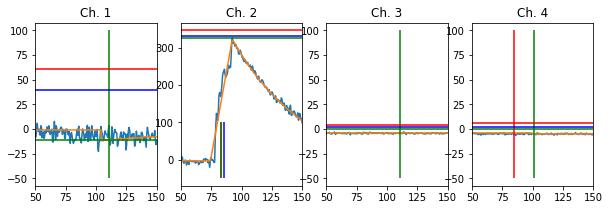

Event Number 84
Channel 1 params: -2.93, 83.6, -0.11, 130.7, -11.53, -0.002
Channel 2 params: -5.19, 87.5, 61.46, 93.3, 1759.17, -0.016
Channel 3 params: -4.94, 104.5, 0.15, 103.0, -1.16, -0.002
Channel 4 params: -4.68, 104.1, 0.07, 101.8, -0.51, -0.003


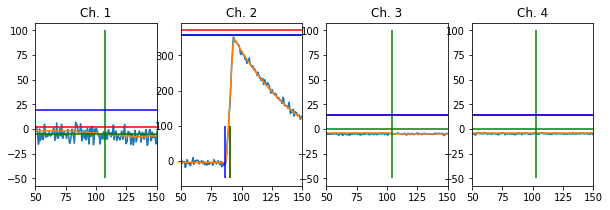

Event Number 85
Channel 1 params: -10.72, 101.5, 0.40, 93.9, -5587.89, -0.000
Channel 2 params: -7.56, 86.4, 31.77, 98.2, 1792.89, -0.015
Channel 3 params: -3.97, 86.7, 3.59, 96.5, 174.54, -0.016
Channel 4 params: -4.58, 86.9, 1.98, 96.7, 99.59, -0.017


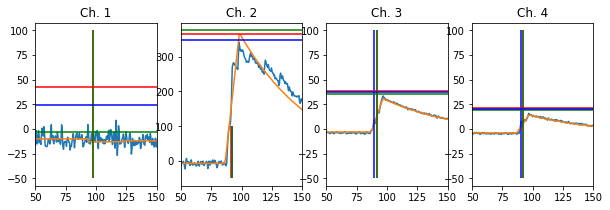

Event Number 86
Channel 1 params: -1.40, 89.2, 59.80, 99.1, 3113.78, -0.016
Channel 2 params: -0.45, 120.7, 1.35, 112.5, -23462.04, -0.000
Channel 3 params: -3.64, 88.0, 1.67, 102.6, 96.55, -0.013
Channel 4 params: -3.83, 88.7, 2.97, 101.1, 171.75, -0.015


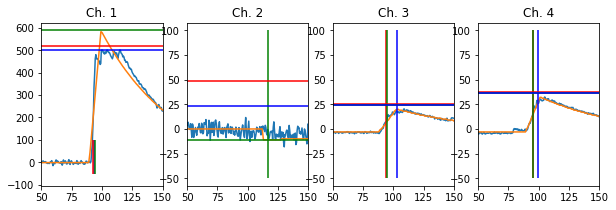

Event Number 87
Channel 1 params: -3.24, 87.5, 44.34, 95.9, 2371.01, -0.019
Channel 2 params: -4.94, 92.4, -0.05, 105.5, -39.03, -0.000
Channel 3 params: -4.85, 101.5, -0.04, 104.0, -181.73, -0.054
Channel 4 params: -4.93, 116.6, 0.01, 123.2, 43.24, -0.094


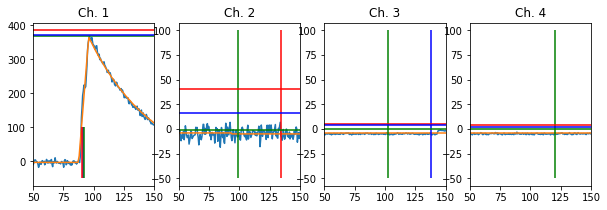

Event Number 88
Channel 1 params: 6.86, 86.8, 48.61, 93.7, 1992.75, -0.018
Channel 2 params: -4.10, 95.5, -0.12, 106.1, -36.21, -0.026
Channel 3 params: -4.40, 100.6, -0.21, 101.2, -0.83, -0.002
Channel 4 params: -4.74, 123.8, 0.02, 97.8, -597.23, -0.064


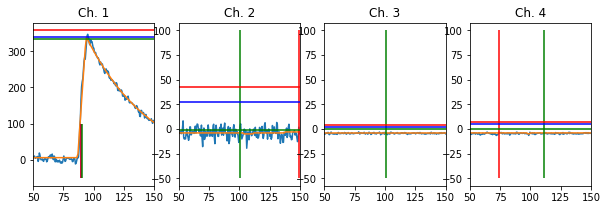

Event Number 89
Channel 1 params: -4.62, 93.5, 96.83, 97.5, 2423.94, -0.018
Channel 2 params: -3.73, 100.6, -0.50, 104.0, -39.58, -0.026
Channel 3 params: -4.76, 129.4, -0.00, 230.5, -11179.28, -0.039
Channel 4 params: -4.87, 232.5, 0.00, 293.7, -3277.61, -0.027


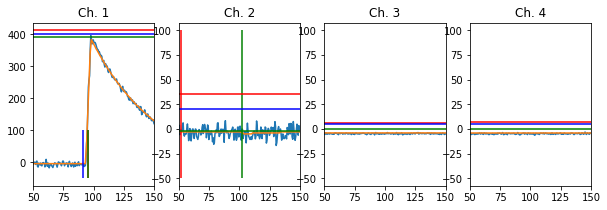

Event Number 90
Channel 1 params: -2.95, 109.8, -1.62, 113.4, -15.45, -0.001
Channel 2 params: -7.29, 86.3, 51.94, 94.0, 1726.44, -0.015
Channel 3 params: -2.48, 116.9, 0.06, 104.2, 34.15, -0.032
Channel 4 params: -4.57, 111.8, -0.04, 117.1, -657.48, -0.000


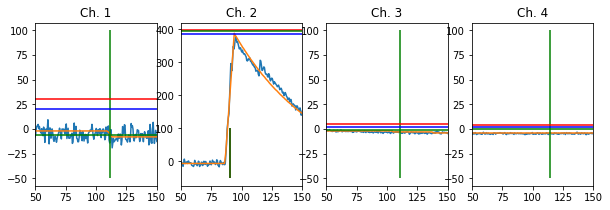

Event Number 91
Channel 1 params: -3.48, 98.7, -0.07, 136.9, -15.17, -0.001
Channel 2 params: -4.94, 94.1, 94.32, 97.9, 1963.83, -0.017
Channel 3 params: -4.48, 106.6, 0.12, 107.5, -151.80, -0.094
Channel 4 params: -5.05, 113.1, -0.19, 113.7, -16.97, -0.000


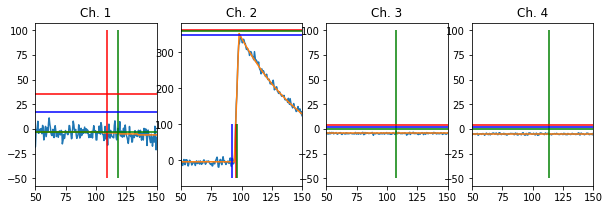

Event Number 92
Channel 1 params: -3.44, 108.2, -0.38, 117.5, -77.57, -0.000
Channel 2 params: -4.83, 92.8, 63.63, 101.2, 2366.15, -0.014
Channel 3 params: -4.70, 100.9, 2.68, 102.4, 79.71, -0.030
Channel 4 params: -4.71, 93.7, 1.42, 103.1, 61.65, -0.015


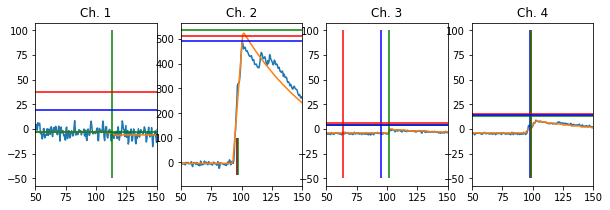

Event Number 93
Channel 1 params: -9.47, 131.7, 0.02, 83.3, -3820.85, -0.000
Channel 2 params: -3.76, 87.1, 34.11, 98.1, 2122.92, -0.017
Channel 3 params: -4.44, 115.1, -0.07, 118.1, -0.81, -0.003
Channel 4 params: -4.61, 108.8, 0.10, 107.1, -1735.60, -0.087


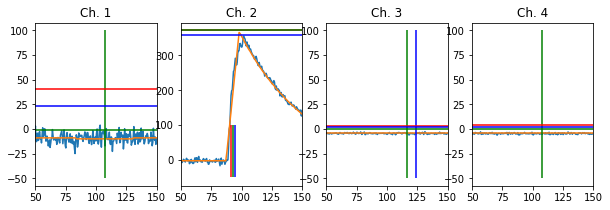

Event Number 94
Channel 1 params: -3.01, 81.8, 31.30, 93.5, 2020.12, -0.017
Channel 2 params: -5.46, 119.5, 16.21, 121.8, 472.98, -0.021
Channel 3 params: -4.90, 101.3, 0.01, 91.4, -362.13, -0.000
Channel 4 params: -4.67, 123.7, 2.40, 125.2, 41.42, -0.020


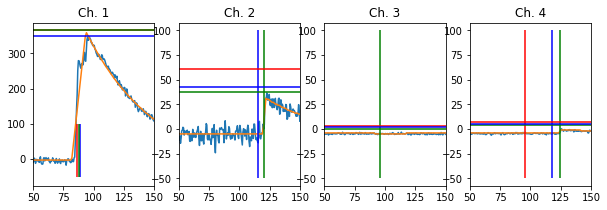

Event Number 95
Channel 1 params: -4.03, 92.1, 54.73, 98.5, 2212.94, -0.018
Channel 2 params: -5.73, 89.4, 19.21, 102.2, 1550.65, -0.017
Channel 3 params: -3.50, 88.3, 3.25, 99.5, 179.41, -0.016
Channel 4 params: -3.94, 90.4, 2.16, 103.4, 157.19, -0.016


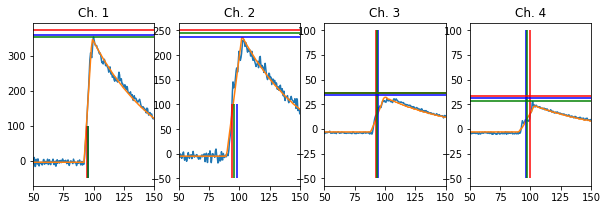

Event Number 96
Channel 1 params: -4.59, 83.1, 25.44, 98.5, 1825.79, -0.015
Channel 2 params: -4.59, 102.7, 0.48, 99.7, -2571.08, -0.000
Channel 3 params: -4.50, 102.9, 0.03, 94.2, -218.38, -0.000
Channel 4 params: -4.68, 46.6, -0.00, 312.7, -41656.72, -0.033


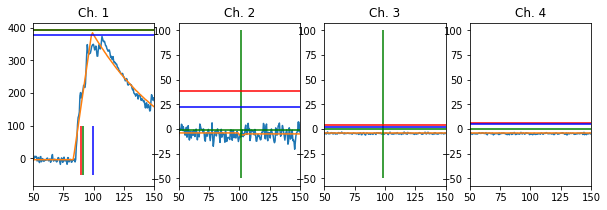

Event Number 97
Channel 1 params: -5.98, 90.7, 79.28, 96.8, 2659.34, -0.017
Channel 2 params: -4.59, 88.9, 18.07, 100.8, 1193.63, -0.016
Channel 3 params: -2.54, 90.2, 1.94, 95.3, 81.65, -0.021
Channel 4 params: -4.66, 93.6, 3.00, 103.5, 187.58, -0.018


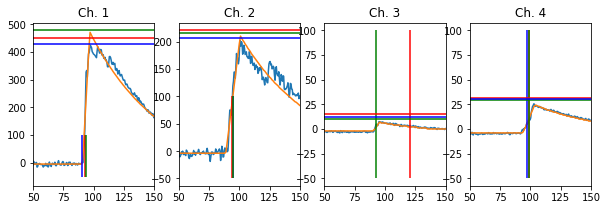

Event Number 98
Channel 1 params: 12.73, 92.8, 43.75, 107.0, 3221.03, -0.014
Channel 2 params: -7.74, 110.0, 0.60, 104.5, -73.12, -0.020
Channel 3 params: -4.41, 100.4, 0.08, 95.3, -160.15, -0.000
Channel 4 params: -4.58, 109.4, 0.00, 149.3, 13.92, -0.082


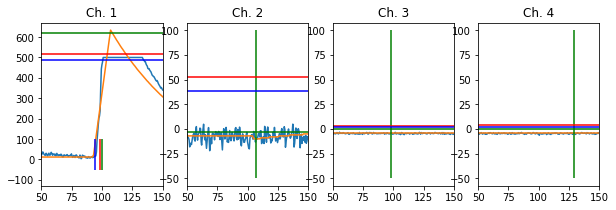

Event Number 99
Channel 1 params: -4.06, 108.8, 1.46, 108.0, -2205.39, -0.000
Channel 2 params: 3.05, 87.8, 65.42, 93.1, 1499.55, -0.015
Channel 3 params: -4.62, 88.1, 0.55, 88.6, 2.44, -0.040
Channel 4 params: -4.65, 173.4, 1.46, 175.8, 82.87, -0.018


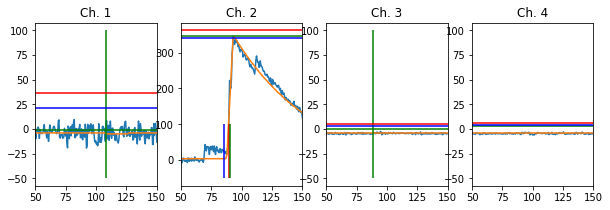

Event Number 100
Channel 1 params: -4.72, 92.9, 61.44, 102.2, 3784.46, -0.018
Channel 2 params: -6.32, 113.2, 0.40, 116.2, 245.05, -0.069
Channel 3 params: -4.42, 91.4, 1.34, 109.1, 105.45, -0.013
Channel 4 params: -4.55, 91.4, 0.16, 126.1, 78.05, -0.021


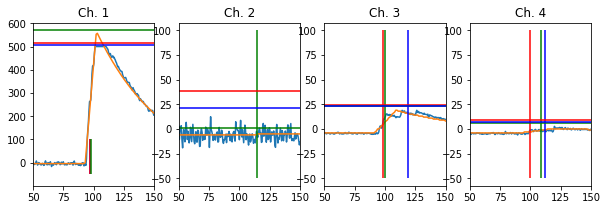

Event Number 101
Channel 1 params: -3.80, 91.3, 36.92, 93.6, 637.58, -0.021
Channel 2 params: -347.48, -37.5, 4.72, 126.6, 4048.11, -0.017
Channel 3 params: -4.65, 112.6, -0.15, 114.1, -10.90, -0.000
Channel 4 params: -4.75, 180.1, -0.01, 209.0, -51.70, -0.000


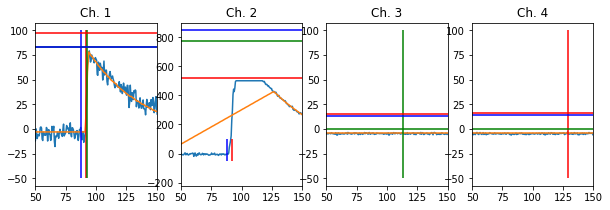

Event Number 102
Channel 1 params: -4.04, 88.8, 53.09, 96.5, 2502.08, -0.018
Channel 2 params: -7.59, 104.4, -0.16, 109.4, -67.48, -0.000
Channel 3 params: -4.39, 107.2, -0.41, 107.9, -8.75, -0.000
Channel 4 params: -4.89, 105.0, -0.01, 121.6, -22.44, -0.000


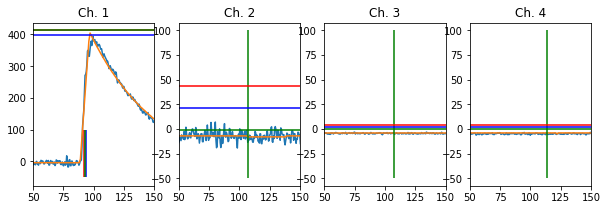

Event Number 103
Channel 1 params: -3.77, 114.2, 1.78, 109.3, -97.60, -0.014
Channel 2 params: 24.76, 91.5, 58.70, 98.9, 2391.06, -0.016
Channel 3 params: -4.35, 97.2, 0.04, 89.5, -1.56, -0.002
Channel 4 params: -3.24, 96.4, 7.53, 97.1, 38.23, -0.017


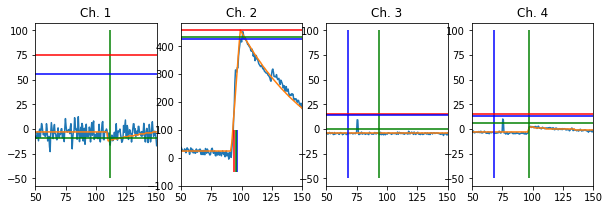

Event Number 104
Channel 1 params: -2.97, 81.7, 24.00, 98.0, 2272.41, -0.017
Channel 2 params: -6.90, 83.2, 5.30, 96.4, 724.55, -0.024
Channel 3 params: -4.58, 83.7, 2.73, 96.0, 125.42, -0.013
Channel 4 params: -4.36, 84.7, 1.87, 98.3, 132.93, -0.017


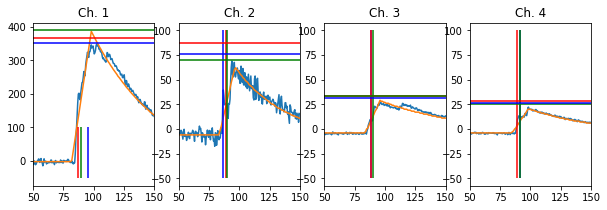

Event Number 105
Channel 1 params: -5.10, 92.3, 51.29, 100.6, 3521.76, -0.021
Channel 2 params: -6.85, 118.7, -1.70, 120.6, -18.92, -0.004
Channel 3 params: -4.95, 89.7, 2.51, 101.5, 141.74, -0.015
Channel 4 params: -4.66, 95.0, 3.73, 100.5, 111.65, -0.017


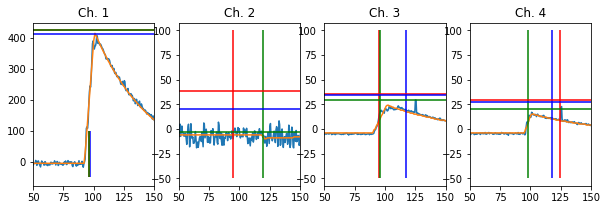

Event Number 106
Channel 1 params: -3.37, 83.8, 37.90, 92.9, 1607.04, -0.016
Channel 2 params: -6.62, 104.7, -0.29, 111.2, -34.04, -0.000
Channel 3 params: -4.64, 81.8, 1.38, 93.6, 84.74, -0.018
Channel 4 params: -3.62, 83.9, 1.48, 96.1, 83.23, -0.015


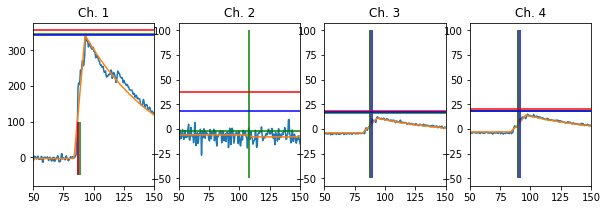

Event Number 107
Channel 1 params: -4.65, 94.5, 70.45, 100.9, 2426.39, -0.016
Channel 2 params: -4.73, 156.7, -0.03, 243.1, -78.20, -0.010
Channel 3 params: -4.53, 109.6, 1.35, 112.3, 33.80, -0.020
Channel 4 params: -4.53, 104.3, 4.39, 105.3, 10.46, -0.008


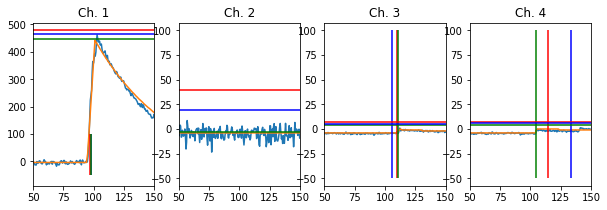

Event Number 108
Channel 1 params: -6.17, 91.6, 43.40, 103.5, 4961.74, -0.022
Channel 2 params: -4.52, 92.2, 23.07, 108.0, 2813.07, -0.018
Channel 3 params: -4.64, 92.8, 4.62, 100.7, 140.77, -0.013
Channel 4 params: -4.55, 94.1, 3.66, 107.8, 291.25, -0.016


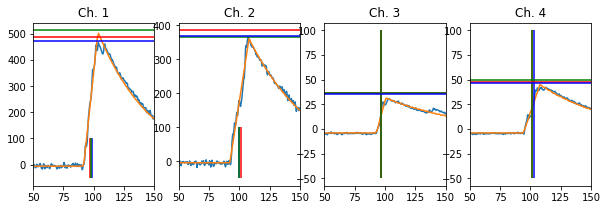

Event Number 109
Channel 1 params: -3.02, 115.9, -0.26, 123.4, -27.50, -0.000
Channel 2 params: -5.44, 83.4, 42.00, 92.3, 1678.19, -0.015
Channel 3 params: -4.21, -2.7, -0.00, 183.6, -2.70, -0.009
Channel 4 params: -4.72, 107.9, -0.05, 110.6, -9.89, -0.000


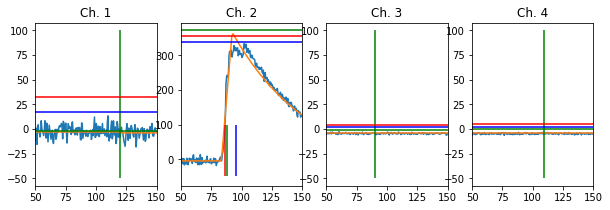

In [ ]:
din = {a+"_"+b:[] for a in channelnames for b in stats}

with open(outputfile, 'w') as w:
    #w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel(s) {channelnum}, stats {stats}")
        with open(inputfiles[i]) as f:
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events  
            
            time = np.array([])
            voltage = [np.array([])]*4
            lines = current_file[j].split('\n')
            
            if eventview: #show the waveform fit line
                print(f"Event Number {j}")
                fig,ax = plt.subplots(1,4,figsize=(10,3))
                ax[0].set_title("Ch. 1")
                ax[1].set_title("Ch. 2")
                ax[2].set_title("Ch. 3")
                ax[3].set_title("Ch. 4")
            
            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                time = np.append(time, float(values[2]))
                for channel in channelnum:
                    #if float(values[channel+2]) < Vcut: continue            #cut the false peaks from the DRS4 -- mismatches length of time list
                    voltage[channel-1] = np.append(voltage[channel-1], float(values[channel+2]))
            w.write('\n')
            for channel in channelnum:
                print(f"Event: {j}, Channel: {channel}",end="\r")
                popt, pcov = curve_fit(waveform, time, voltage[channel-1],p0=p0[channel-1],
                                       maxfev = 100000)#,bounds=([-10,60,0,60,0,-1],[10,140,100,140,3000,0])
                #calculate chi^2
                if do_chi2:
                    chisq = get_chi2(popt,time,voltage[channel-1])
                    din[f'ch{channel}_chisq'].append(chisq)
                    w.write(f"{chisq:.2f}\t")
                
                #calculate amplitude
                if do_amplitude_raw: 
                    amplitude = get_amplitude_raw(voltage[channel-1])
                    din[f'ch{channel}_P2P_raw'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                
                if do_amplitude_base: 
                    amplitude = get_amplitude_base(popt,voltage[channel-1])
                    din[f'ch{channel}_P2P_base'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                    
                if do_amplitude_fit: 
                    amplitude = get_amplitude_fit(popt)
                    din[f'ch{channel}_P2P_fit'].append(amplitude)
                    w.write(f"{amplitude:.1f}\t")
                
                #calculate time
                if do_time_raw: 
                    pulse_time = get_time_raw(time,voltage[channel-1])
                    din[f'ch{channel}_time_raw'].append(pulse_time)
                    w.write(f"{pulse_time:.1f}\t")
                    
                if do_time_fit: 
                    pulse_time = get_time_fit(popt)
                    din[f'ch{channel}_time_fit'].append(pulse_time)
                    w.write(f"{pulse_time:.1f}\t")
                    
                if do_time_half:
                    pulse_time = get_time_half(time, voltage[channel - 1])
                    din[f'ch{channel}_time_half'].append(pulse_time)
                    w.write(f"{pulse_time:.1f}\t")
                   
                if eventview: #show the waveform fit line
                    print(f"Channel {channel} params: {popt[0]:.2f}, {popt[1]:.1f}, {popt[2]:.2f}, {popt[3]:.1f}, {popt[4]:.2f}, {popt[5]:.3f}")
                    xs = []
                    ys = []
                    for i in range(500):
                        xs.append(i)
                        ys.append(waveform(i,*popt))
                    ax[channel-1].plot(time,voltage[channel-1],label="raw")
                    ax[channel-1].plot(xs,ys,label="fit")
                    ax[channel-1].set_xlim(50,150)
                    #draw the P2P and time
                    if do_time_half: ax[channel-1].vlines(get_time_half(time,voltage[channel-1]),ymin=-50,ymax=100, color='b',label="t__half")
                    if do_time_raw: ax[channel-1].vlines(get_time_raw(time,voltage[channel-1]),ymin=-50,ymax=100, color='r',label="t_raw")
                    if do_time_fit: ax[channel-1].vlines(get_time_fit(popt),ymin=-50,ymax=100, color='g',label="t_fit")
                    if do_amplitude_raw: ax[channel-1].hlines(get_amplitude_raw(voltage[channel-1]),xmin=0,xmax=200, color='r',label="A_raw")
                    if do_amplitude_fit: ax[channel-1].hlines(get_amplitude_fit(popt),xmin=0,xmax=200, color='g',label="A_fit")
                    if do_amplitude_base: ax[channel-1].hlines(get_amplitude_base(popt,voltage[channel-1]),xmin=0,xmax=200, color='b',label="A_base")
            #plt.legend()
            plt.show()
                
print(f'Done!\nTotal events analyzed: {len(din["ch2_chisq"])}')
dfin = pd.DataFrame(din)

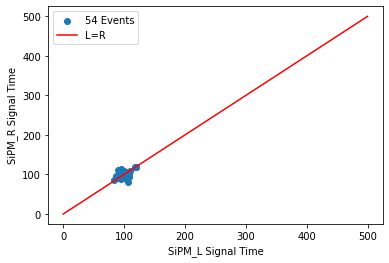

In [344]:
plt.scatter(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_half,dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_half,label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_half)} Events")
plt.plot(np.linspace(0,500,2),np.linspace(0,500,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

### How to read the output file into DataFrame:

In [ ]:
with open(outputfile) as f:  
    stats = []
    nchannelnames=[]
    nevents = (f.read().split('\n'))
    nchannelnums = nevents[0].split('[')[1].split(']')[0].split(', ')
    for ch in nchannelnums:
        nchannelnames.append(f'ch{ch}')
    for i in range(len(nevents[0].split('[')[2].split(']')[0].split("'"))//2):
        stats.append(nevents[0].split('[')[2].split(']')[0].split("'")[2*i+1])

    dout = {a+"_"+b:[] for a in nchannelnames for b in stats}
    for event in nevents[:]:
        #print(f'Event: {event}')
        nvalues = event.split()
        if len(nvalues) != len(stats)*len(nchannelnames): continue
        for i in range(len(nchannelnames)):
            for j in range(len(stats)):
                dout[f'{nchannelnames[i]}_{stats[j]}'].append(float(nvalues[len(stats)*i+j]))
    #print(dout)
dfout = pd.DataFrame(dout)

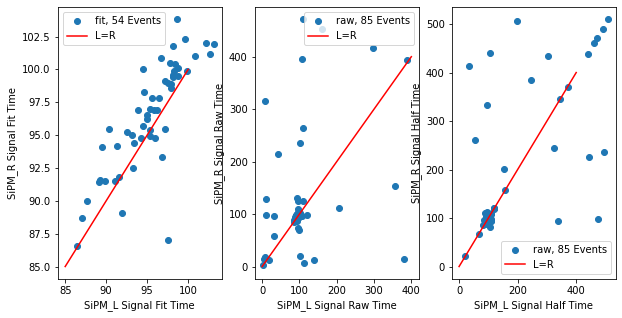

In [386]:
fig,ax=plt.subplots(1,3,figsize=(10,5))

ax[0].scatter(dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"fit, {len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
ax[1].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")
ax[2].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_half,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_half,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_half)} Events")
ax[0].plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
ax[0].set_xlabel("SiPM_L Signal Fit Time")
ax[0].set_ylabel("SiPM_R Signal Fit Time")
ax[1].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[1].set_xlabel("SiPM_L Signal Raw Time")
ax[1].set_ylabel("SiPM_R Signal Raw Time")
ax[2].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[2].set_xlabel("SiPM_L Signal Half Time")
ax[2].set_ylabel("SiPM_R Signal Half Time")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

Actual Average: 1.12, Actual st.dev.: 2.44
Fit Average:    1.37, Fit st.dev.:    1.41


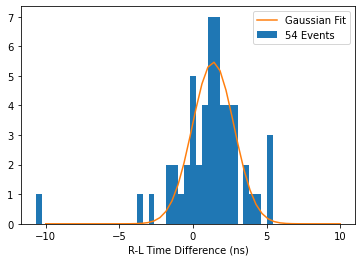

In [27]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit-dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,40, label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.legend()
plt.show()